<a href="https://colab.research.google.com/github/cesarriat/mlir/blob/master/Copy_of_MiPrimeraApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

In [0]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [0]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [0]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
12860,-121.8,37.3,23.0,7609.0,1446.0,6034.0,1414.0,4.8,195.3
3095,-117.8,33.9,24.0,2168.0,421.0,1050.0,397.0,4.6,238.3
10943,-120.9,37.6,32.0,4579.0,914.0,2742.0,856.0,2.7,86.2
4162,-118.0,33.9,30.0,2395.0,565.0,1214.0,521.0,3.7,212.3
14135,-122.1,37.9,25.0,7201.0,1521.0,3264.0,1433.0,3.7,252.1
...,...,...,...,...,...,...,...,...,...
4493,-118.0,34.0,36.0,2722.0,515.0,1390.0,486.0,3.8,178.5
6115,-118.2,34.1,45.0,1747.0,484.0,1680.0,441.0,2.6,155.5
3515,-117.9,33.8,26.0,2678.0,702.0,3262.0,685.0,3.7,176.8
13153,-121.9,37.4,37.0,1525.0,363.0,1075.0,374.0,2.9,186.1


In [0]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [0]:

# Primer Paso: Definir las características y configurar las denominadas columnas de características

# Definir la característica de entrada: total_rooms.
my_feature = california_housing_dataframe [["total_rooms"]]

In [0]:
# Configurar una columna numérica de característica para total_rooms.
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

In [0]:
# Segundo Paso : Definir el Objetivo (Target)

# Definir la etiqueta.
targets = california_housing_dataframe["median_house_value"]

In [0]:
# Tercer Paso: Configurar el LinearRegressor

# Usar descenso de gradiente como el optimizador para entrenar el modelo.
# Configurar una tasa de aprendizaje de 0.0000001 para Descenso de Gradiente.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

In [0]:
# Configurar el modelo de regresión lineal con nuestras columnas característica y optimizador.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

**Cuarto Paso: Definir la Función input**

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Entrena un modelo de regresión lineal de una característica.
  
    Argumentos:
      features:DataFrame pandas de característicass
      targets: DataFrame pandas de objetivos
      batch_size: Tamaño de lotes pasados al modelo
      shuffle: True or False. Si se deben mezclar los datos.
      num_epochs: Número de epochs por los que los datos se repetirán. None = repetir indefinidamente
    Devuelve:
      Tuple de (features, labels) para el siguiente lote de datos
    """
  
    # Convertir datos pandas en un dict de arrays np.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construir un dataset, y configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Mezclar los datos, si se especifica.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Devolver el nuevo lote de datos.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

**Paso cinco: Entrenar el Modelo**

In [0]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

In [0]:
_

**Paso seis: Evaluar el Modelo**

In [0]:

# Crear una función input para predicciones.
# Nota: Como vamos a hacer sólo una predicción para cada ejemplo, no tenemos 
# que repetir o mezclar los datos aquí.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)


# Llamar a predict() en el linear_regressor para hacer predicciones.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Formateamos las predicciones como un array NumPy, para que podamos calcular las métricas de error.
predictions = np.array([item['predictions'][0] for item in predictions])

# Imprimimos Error Cuadrático Medio y Raíz Error Cuadrático Medio.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Error Cuadrático Medio (en datos entrenamiento): %0.3f" % mean_squared_error)
print("Raíz Error Cuadrático Medio (en datos entrenamiento): %0.3f" % root_mean_squared_error)

Error Cuadrático Medio (en datos entrenamiento): 56367.025
Raíz Error Cuadrático Medio (en datos entrenamiento): 237.417


In [0]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Diferencia entre Min. y Max.: %0.3f" % min_max_difference)
print("Raíz Error Cuadrático Medio: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Diferencia entre Min. y Max.: 485.002
Raíz Error Cuadrático Medio: 237.417


In [0]:
calibration_data = pd.DataFrame()
calibration_data["predicciones"] = pd.Series(predictions)
calibration_data["objetivos"] = pd.Series(targets)
calibration_data.describe()

,predicciones,objetivos
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


In [0]:
sample = california_housing_dataframe.sample(n=300)

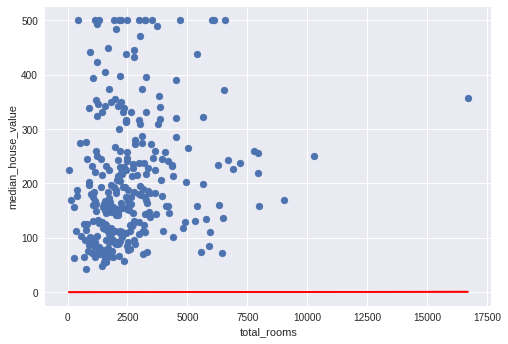

In [0]:
# Obtenemos los valores mínimo y máximo de total_rooms.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Recuperamos el peso y sesgo final generado durante el entrenamiento.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Obtener los median_house_values predichos para los valores min and max total_rooms.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Trazamos nuestra línea de regresión desde (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Trazamos nuestra línea de regresión desde (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Damos nombre a los ejes del gráfico.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Trazamos una gráfica de dispersión de nuestros datos sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Mostrar gráfico.
plt.show()

In [0]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Entrenar un modelo de regresión lineal de una característica.
  
  Args:
    learning_rate: Un `float`, la tasa de aprendizaje.
    steps: Un no-cero `int`, el número total de pasos de entrenamiento. Un paso de entrenamiento
      consiste en un paso adelante y atrás usando un único lote.
    batch_size: Un no-cero `int`, tamaño del lote.
    input_feature: un `string` especificando una columna de `california_housing_dataframe`
      para usar como característica de entrada.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Crear columns característica.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Crear funciones input.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Crear un objeto linear regressor.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Configuración para trazar el estado de la línea de nuestro modelo cada período.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Línea aprendida por Período")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Entrena el modelo, pero haciéndolo dentro de un loop de modo que podamos periódicamente
  # evaluar las métricas de pérdida.
  print("Entrenamiento del modelo...")
  print("RMSE (en datos de entrenamiento):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Entrenar el modelo, empezando desde el estado anterior.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Tómate un descanso y calcula las predicciones.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Calcular pérdida.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Ocasionalmente imprimir la pérdida actual.
    print("  período %02d : %0.2f" % (period, root_mean_squared_error))
    # Agregar las métricas de pérdida de este período a nuestra lista.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Por último, rastrea los pesos y los sesgos a lo largo del tiempo.
    # Aplica algo de math para asegurarte que los datos y la línea se representan claramente.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Entrenamiento del Modelo finalizado.")

  # Muestra un gráfico de métricas de pérdida por períodos.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Períodos')
  plt.title("Raíz Error Cuádratico Medio vs. Períodos")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Muestra una tabla con los datos de calibración.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("RMSE final(en datos de entrenamiento): %0.2f" % root_mean_squared_error)

Entrenamiento del modelo...
RMSE (en datos de entrenamiento):
  período 00 : 236.32
  período 01 : 235.11
  período 02 : 233.90
  período 03 : 232.70
  período 04 : 231.50
  período 05 : 230.31
  período 06 : 229.13
  período 07 : 227.96
  período 08 : 226.79
  período 09 : 225.63
Entrenamiento del Modelo finalizado.


,predictions,targets
count,17000.0,17000.0
mean,13.2,207.3
std,10.9,116.0
min,0.0,15.0
25%,7.3,119.4
50%,10.6,180.4
75%,15.8,265.0
max,189.7,500.0


RMSE final(en datos de entrenamiento): 225.63


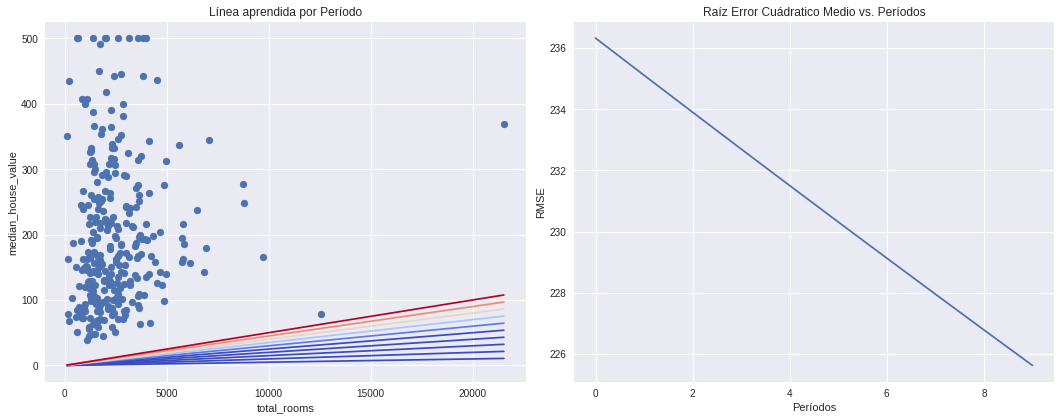

In [0]:
train_model(
    learning_rate=0.00001,
    steps=100,
    batch_size=1
)

Entrenamiento del modelo...
RMSE (en datos de entrenamiento):
  período 00 : 225.63
  período 01 : 214.42
  período 02 : 204.04
  período 03 : 195.33
  período 04 : 187.55
  período 05 : 180.80
  período 06 : 175.00
  período 07 : 171.07
  período 08 : 168.50
  período 09 : 166.90
Entrenamiento del Modelo finalizado.


,predictions,targets
count,17000.0,17000.0
mean,120.0,207.3
std,99.0,116.0
min,0.1,15.0
25%,66.4,119.4
50%,96.6,180.4
75%,143.1,265.0
max,1722.3,500.0


RMSE final(en datos de entrenamiento): 166.90


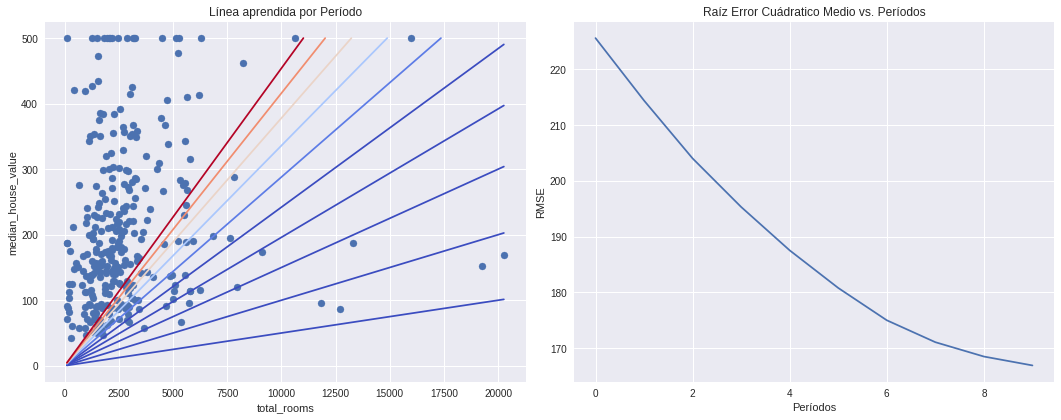

In [0]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)

Entrenamiento del modelo...
RMSE (en datos de entrenamiento):
  período 00 : 225.63
  período 01 : 214.62
  período 02 : 204.86
  período 03 : 196.26
  período 04 : 189.66
  período 05 : 184.13
  período 06 : 181.10
  período 07 : 178.68
  período 08 : 177.12
  período 09 : 176.22
Entrenamiento del Modelo finalizado.


,predictions,targets
count,17000.0,17000.0
mean,116.4,207.3
std,93.4,116.0
min,0.2,15.0
25%,64.3,119.4
50%,95.0,180.4
75%,140.1,265.0
max,2904.3,500.0


RMSE final(en datos de entrenamiento): 176.22


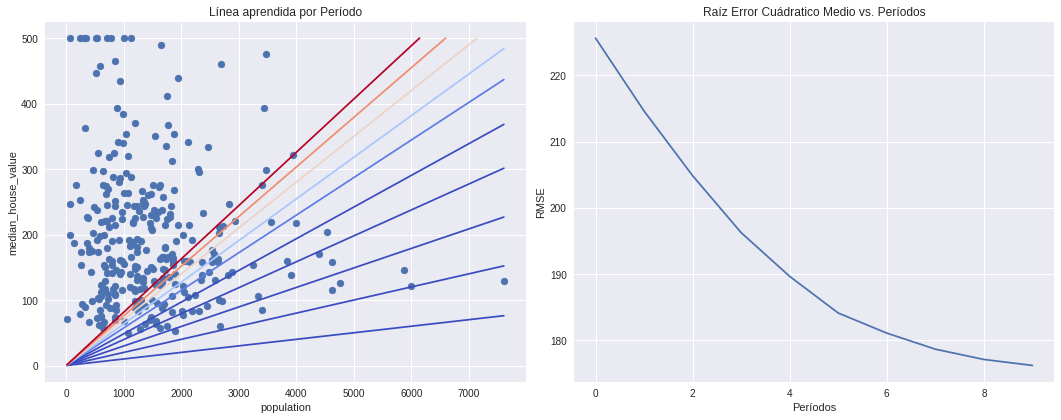

In [0]:
train_model(
    learning_rate=0.00002,
    steps=1000,
    batch_size=5,
    input_feature="population"
)